In [1]:
import math
import datetime
import os, sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2




# local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
import training

In [2]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 


# Model parameters
BATCH_SIZE = 128 #original 128
GAMMA = 0.999
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY_steps = 4000 
EPS_DECAY = (EPS_START - EPS_END)/EPS_DECAY_steps
REPLAY_START_SIZE =  1500
TARGET_UPDATE = 10 #episodes
DEVICE = 'cuda:0'
MEMORY_CAPACITY = 12000

# agent = model.DoubleDQNAgent(imsize=IMSIZE, 
#                  in_channels=STACK_SIZE,
#                  n_actions=N_ACTIONS,
#                  memory_capacity=MEMORY_CAPACITY,
#                  eps_start=EPS_START,
#                  eps_end=EPS_END,
#                  eps_delta=EPS_DECAY,
#                  gamma_discount = GAMMA,
#                  batch_size = BATCH_SIZE,
#                  device=DEVICE)


# Optimizer Parameters
LR_DQN = 0.01

# optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

In [3]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)



In [ ]:
## Training parameters 
MAX_EPISODES = 500 # number of episodes (an episode ends after agent hits a box)
MAX_STEPS  = 5e4  # number of optimization steps (each time step the model parameters are updated)
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:True,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Training configuration dictionary
cfg = dict()
# cfg['seed']                     = SEED
# cfg['training_condition']       = TRAINING_CONDITION 
cfg['max_episodes']             = MAX_EPISODES
# cfg['model_path']               = MODEL_PATH
cfg['max_steps']                = MAX_STEPS
cfg['target_update']            = TARGET_UPDATE
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL
cfg['replay_start_size']        = REPLAY_START_SIZE
# cfg['logfile']                  = LOGFILE

for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
   
            
        
            # Condition-specific configuration
            cfg['training_condition'] = 0 if complexity == 'plain' else 1 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            cfg['seed'] = seed
            torch.manual_seed(seed)
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity,phosphene_resolution,seed)
            print(model_name)
            cfg['logfile'] = 'Out/Exp1/{}_train_stats.csv'.format(model_name)
            cfg['model_path'] = 'Out/Exp1/{}_best_model.pth'.format(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 memory_capacity=MEMORY_CAPACITY,
                 eps_start=EPS_START,
                 eps_end=EPS_END,
                 eps_delta=EPS_DECAY,
                 gamma_discount = GAMMA,
                 batch_size = BATCH_SIZE,
                 device=DEVICE)

            optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

            # Start training
            training.train(agent, environment, img_processing, optimizer, cfg)
            print('finished training')

exp1_plain_phosNone_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 475 wall_collisions: 0, box_collisions: 50, endless_loops: 0, total_reward: 3300
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 488 wall_collisions: 0, box_collisions: 35, endless_loops: 0, total_reward: 3737
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, tar

episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 475 wall_collisions: 0, box_collisions: 50, endless_loops: 0, total_reward: 3300
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 481 wall_collisions: 0, box_collisions: 46, endless_loops: 0, total_reward: 3414
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 504 wall_collisions: 0, box_collisions: 27, endless_loops: 0, total_reward: 3961
new best model
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 438 wall_collisions: 0, box_collisions: 7, endless_loops: 1, total_reward: 3813
episode 250, ta

episode 140, target net updated
step count 484 wall_collisions: 0, box_collisions: 41, endless_loops: 0, total_reward: 3561
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 409 wall_collisions: 9, box_collisions: 18, endless_loops: 2, total_reward: 3200
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 351 wall_collisions: 12, box_collisions: 2, endless_loops: 3, total_reward: 2864
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 525 wall_collisions: 0, box_collisions: 7, endless_loops: 0, total_reward: 4573
new best model
episode 300, target net updated
episode 310, target net updated
episode 320, target net upd

episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 421 wall_collisions: 2, box_collisions: 7, endless_loops: 3, total_reward: 3438
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 441 wall_collisions: 6, box_collisions: 3, endless_loops: 3, total_reward: 3667
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 454 wall_collisions: 8, box_collisions: 4, endless_loops: 2, total_reward: 3727
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 425 wall_collisions: 12, box_collisions: 2, endless_loops: 4, total_reward: 3384
episode 400, target net upd

episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 509 wall_collisions: 11, box_collisions: 5, endless_loops: 2, total_reward: 4154
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 434 wall_collisions: 0, box_collisions: 0, endless_loops: 3, total_reward: 3807
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 525 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 4720
new best model
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
finished training
exp1_plain_phos42_S3
step count 25 wall_collisions: 25, box_collisions: 0, endless_lo

step count 418 wall_collisions: 0, box_collisions: 3, endless_loops: 2, total_reward: 3667
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 418 wall_collisions: 8, box_collisions: 10, endless_loops: 5, total_reward: 3143
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
finished training
exp1_plain_phos34_S1
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 43 wall_collisions: 32, box_collisions: 0, endless_loops: 5, total_reward: -215
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net update

episode 490, target net updated
finished training
exp1_plain_phos34_S4
step count 475 wall_collisions: 0, box_collisions: 50, endless_loops: 0, total_reward: 3300
new best model
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 42 wall_collisions: 32, box_collisions: 1, endless_loops: 5, total_reward: -255
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 475 wall_collisions: 0, box_collisions: 50, endless_loops: 0, total_reward: 3300
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 485 wall_collisions: 0, box_collisions: 42, endless_loops: 0, total_reward: 3530
new best model
episode 150, target net updated
episode 160, target net updated

episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 475 wall_collisions: 0, box_collisions: 50, endless_loops: 0, total_reward: 3300
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 486 wall_collisions: 0, box_collisions: 35, endless_loops: 0, total_reward: 3739
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 405 wall_collisions: 12, box_collisions: 6, endless_loops: 4, total_reward: 3108
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 484 wall_collisions: 0, box_collisions: 0, endless_loops: 2, total_reward: 4219
new best model

episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 521 wall_collisions: 1, box_collisions: 17, endless_loops: 0, total_reward: 4235
new best model
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 520 wall_collisions: 0, box_collisions: 21, endless_loops: 1, total_reward: 4026
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 457 wall_collisions: 0, box_collisions: 11, endless_loops: 1, total_reward: 3696
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 385 wall_collisions: 0, box_collisions: 2, endless_loops: 3, total_reward: 3268
episode 35

step count 468 wall_collisions: 0, box_collisions: 10, endless_loops: 2, total_reward: 3935
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 510 wall_collisions: 0, box_collisions: 4, endless_loops: 1, total_reward: 4370
new best model
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 384 wall_collisions: 1, box_collisions: 1, endless_loops: 2, total_reward: 3224
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 499 wall_collisions: 0, box_collisions: 1, endless_loops: 1, total_reward: 4284
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440,

In [5]:
# EXAMPLES = 10

# i = 0
# bad_choices = [(state, action, next_state,reward) for (state, action, next_state,reward) in agent.memory.memory if reward<0 and action ==0]
# # for state, action, next_state, reward in agent.memory.memory[:EXAMPLES]:
# for state, action, next_state, reward in bad_choices[:EXAMPLES]:
#     i+=1
    
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward.item()))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
    
# # plt.tight_layout()


## Validation:

In [1]:
import torch
import cv2
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# # local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
from testing import test

#### Run models on test environment:

In [2]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)
    
img_processing = ImageProcessor

In [ ]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 

# Model parameters
BATCH_SIZE = 128 #original 128
DEVICE = 'cpu'

agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)


## Testing parameters 
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:False,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Testing configuration dictionary
cfg = dict()
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL

test_data = []
for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
            
            # Condition-specific configuration
            cfg['training_condition']       = 2 if complexity == 'plain' else 3 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            model_path = 'Out/Exp1/{}_best_model.pth'.format(model_name)
            print(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)
            agent.policy_net.load_state_dict(torch.load(model_path,map_location=DEVICE))

            # Testing
            conditions = {'complexity': complexity, 'phosphene_resolution': phosphene_resolution, 'seed' : seed}
            results = test(agent, environment, img_processing, cfg)
            test_data.append({**conditions,**results})
data = pd.DataFrame(test_data)
data.to_csv('Out/Exp1/_test_results.csv', index=False)

exp1_plain_phosNone_S0
exp1_plain_phosNone_S1
exp1_plain_phosNone_S2
exp1_plain_phosNone_S3
exp1_plain_phosNone_S4
exp1_plain_phos50_S0
exp1_plain_phos50_S1
exp1_plain_phos50_S2
exp1_plain_phos50_S3
exp1_plain_phos50_S4
exp1_plain_phos42_S0
exp1_plain_phos42_S1
exp1_plain_phos42_S2
exp1_plain_phos42_S3
exp1_plain_phos42_S4
exp1_plain_phos34_S0
exp1_plain_phos34_S1
exp1_plain_phos34_S2


In [19]:
test_data = pd.read_csv('./Out/Exp1/_test_results.csv') 

,complexity,phosphene_resolution,seed,wall_collisions,box_collisions,endless_loops,step_count,cumulative_reward
0,plain,NaN,0,0,1,0,109,917
1,plain,NaN,1,0,2,1,113,883
2,plain,NaN,2,1,3,1,118,850
3,plain,NaN,3,0,3,1,111,855
4,plain,NaN,4,0,5,4,122,784
...,...,...,...,...,...,...,...,...
65,complex,10.0,0,29,17,4,140,200
66,complex,10.0,1,57,7,9,188,145
67,complex,10.0,2,1,18,1,117,423
68,complex,10.0,3,223,8,41,352,-1532


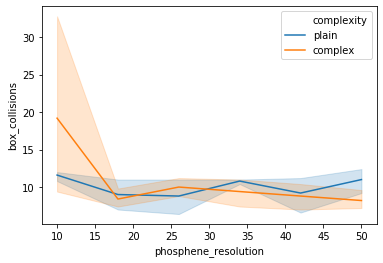

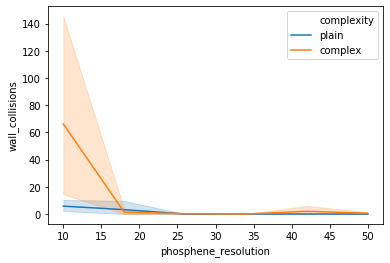

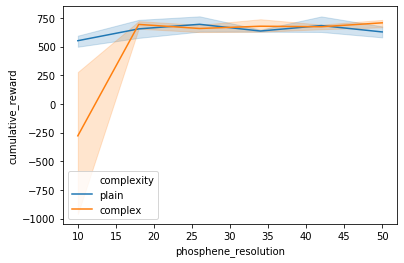

In [22]:
sns.lineplot(data=data,x='phosphene_resolution', y='box_collisions', hue='complexity')
plt.show()
sns.lineplot(data=data,x='phosphene_resolution', y='wall_collisions', hue='complexity')
plt.show()
sns.lineplot(data=data,x='phosphene_resolution', y='cumulative_reward', hue='complexity')

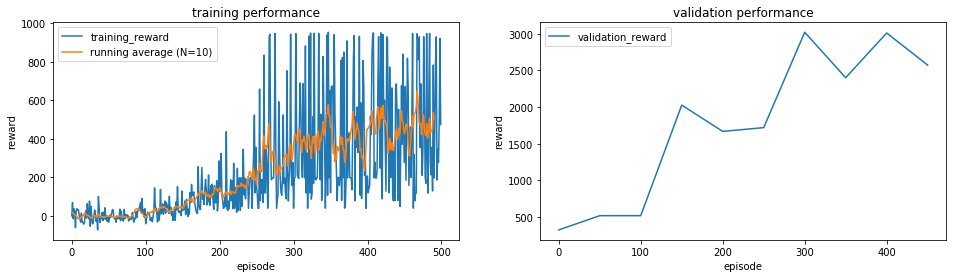

In [17]:
MODEL_NAME = 'exp1_plain_phos18_S2'
stats = pd.read_csv('./Out/Exp1/{}_train_stats.csv'.format(MODEL_NAME))
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()
